In [9]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection._split import train_test_split
from skater.core.visualizer.tree_visualizer import plot_tree, tree_to_text
from skater.util.dataops import show_in_notebook

import numpy as np
import pandas as pd

In [10]:
X, y = make_moons(1000, noise=0.5)

X = pd.DataFrame(X, columns=['F1', 'F2'])
print(np.unique(y))
print(X.columns)
print("*List the feature type* \n", X.dtypes)
X.head()

[0 1]
Index(['F1', 'F2'], dtype='object')
*List the feature type* 
 F1    float64
F2    float64
dtype: object


,F1,F2
0,1.588710,-0.169655
1,-0.108387,-0.587533
2,-0.308215,0.300366
3,1.355678,-0.567374
4,-0.001512,-0.199885


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
classifier_est = DecisionTreeClassifier(max_depth=5, random_state=5)
classifier_est.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

In [12]:
y_hat_train = classifier_est.predict(X_train)
y_hat = classifier_est.predict(X_test)

In [13]:
from sklearn.metrics import classification_report

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.92      0.80      0.86       380
    class 1       0.82      0.93      0.87       370

avg / total       0.87      0.87      0.86       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.86      0.78      0.82       120
    class 1       0.81      0.88      0.85       130

avg / total       0.83      0.83      0.83       250



In [14]:
g_inst = plot_tree(classifier_est, color_list=['coral', 'darkturquoise'], feature_names=X.columns, class_names=target_names)
g_inst.write_png("original_tree.png")

True

2018-09-05 23:54:43,567 - skater.util.dataops - INFO - File Name: original_tree.png


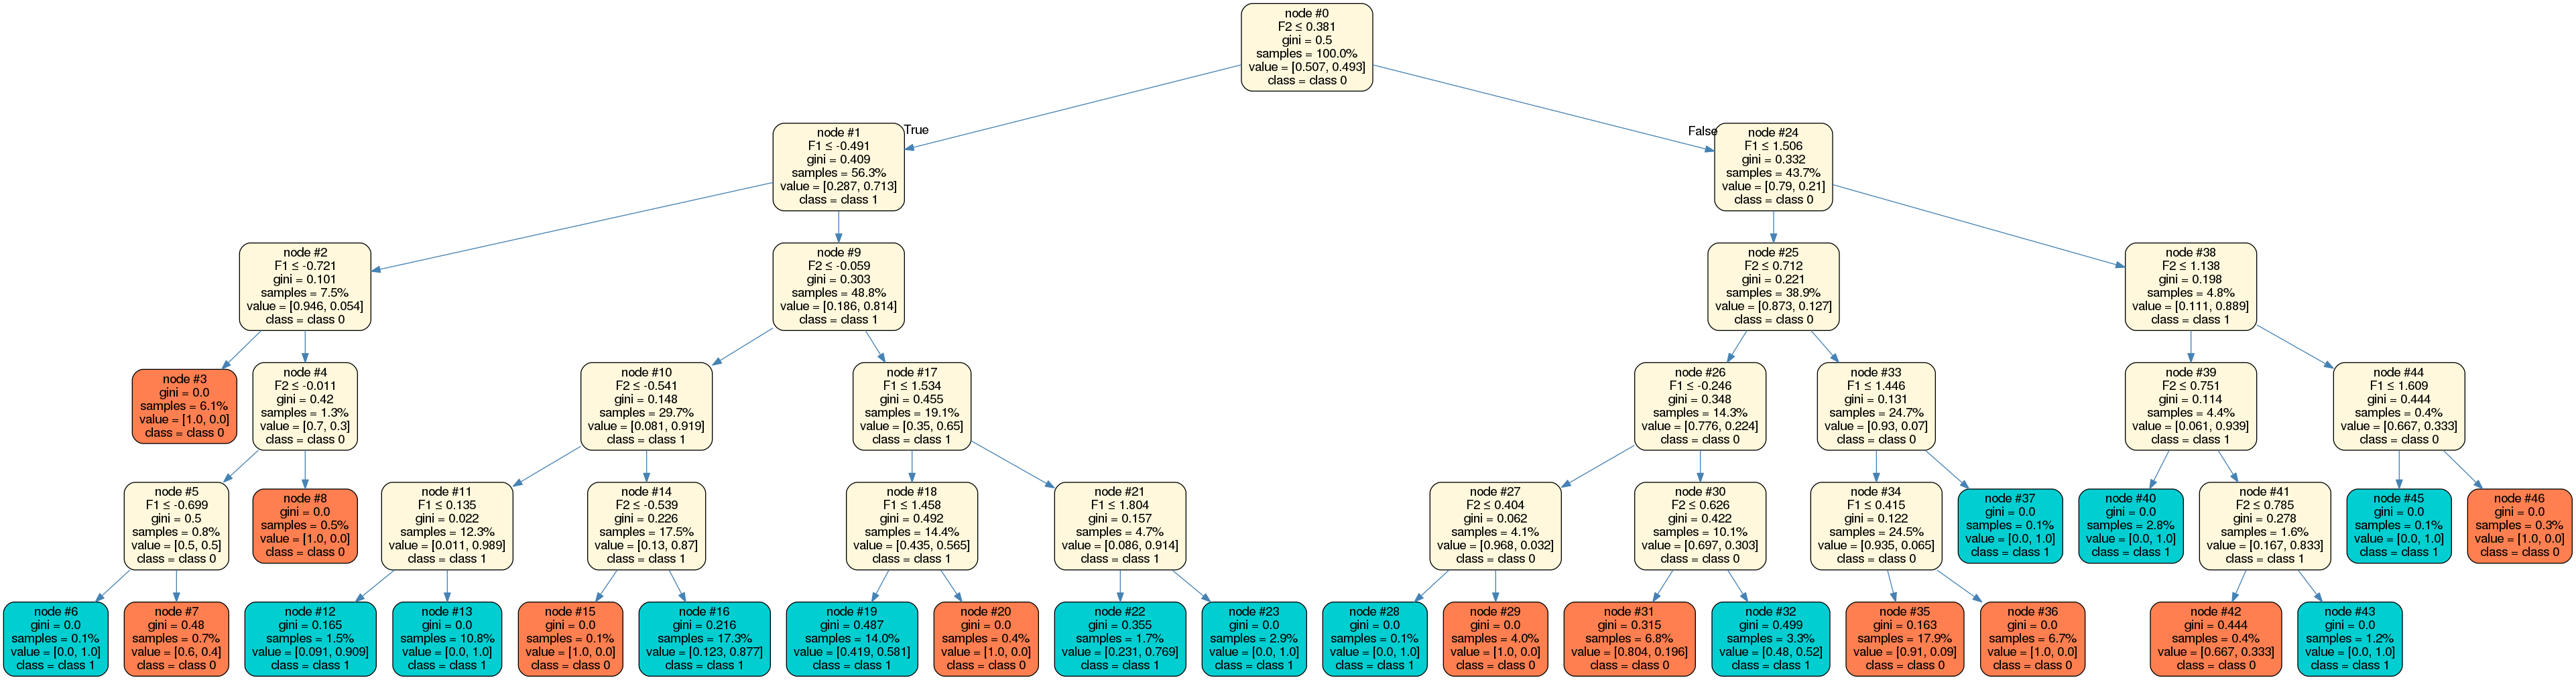

In [15]:
show_in_notebook('original_tree.png', width=1200, height=500)

## Generating explanations using Tree based Surrogates

In [16]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO, _DEBUG

interpreter = Interpretation(X_train, feature_names=X.columns)
model_inst = InMemoryModel(classifier_est.predict, examples=X_train, model_type='classifier', unique_values=[0, 1],
                           feature_names=X.columns, target_names=target_names, log_level=_INFO)

# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)

#### 1. Using Pre-pruning

In [20]:
# 1. Learner is trained on the decisions of the base model when use_oracle=True; when 'False' original labels are used
# to learn a more interpretable tree based model.

# 2. Learner uses F1 metric as the default metric of choice for classification.
# set verbose=True for more detailed information
surrogate_explainer.learn(X_train, y_train, use_oracle=True, prune='pre', scorer_type='default')

2018-09-05 23:57:35,373 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-05 23:57:35,521 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750,)
2018-09-05 23:57:35,523 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.984; oracle score 0.865


-0.119

In [21]:
y_hat_train_s_pre = surrogate_explainer.predict(X_train)
y_hat_s_pre = surrogate_explainer.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_pre, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_pre, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.92      0.78      0.84       380
    class 1       0.80      0.93      0.86       370

avg / total       0.86      0.85      0.85       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.89      0.79      0.84       120
    class 1       0.83      0.91      0.86       130

avg / total       0.86      0.85      0.85       250



2018-09-05 23:57:39,355 - skater.util.dataops - INFO - File Name: test_tree_pre.png


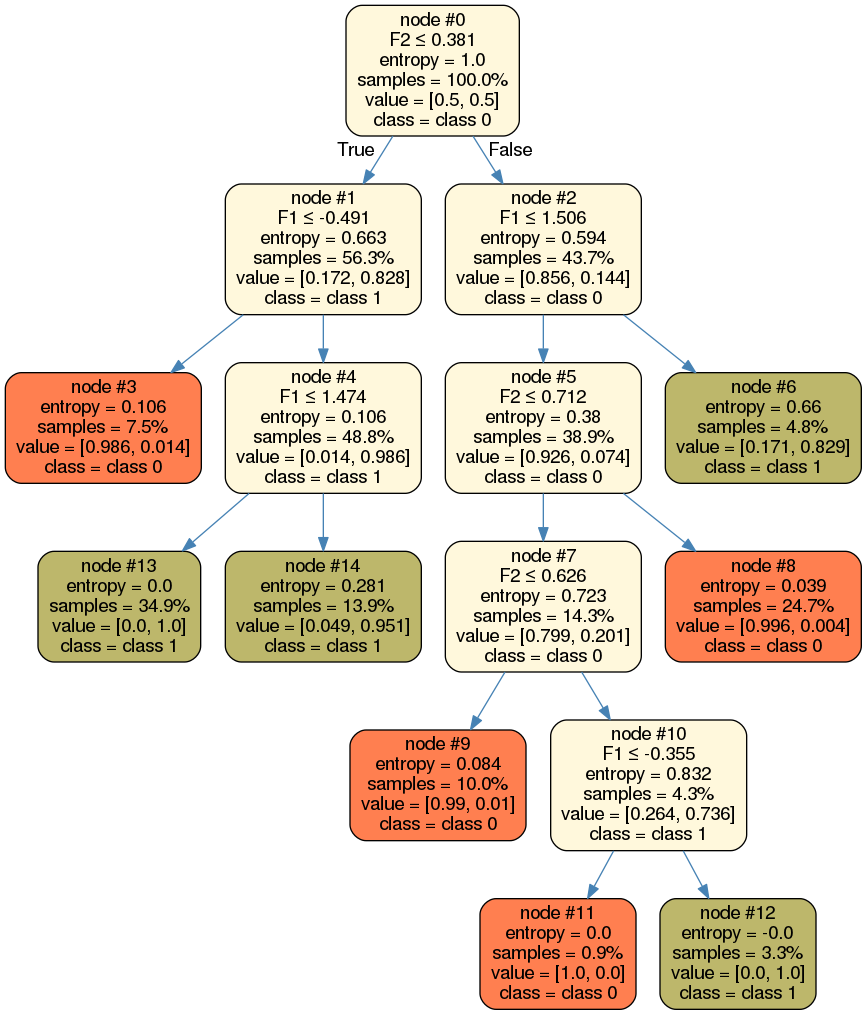

In [22]:
# Only the leaf notes(containing the respective class labels) are colored
surrogate_explainer.plot_global_decisions(colors=['coral', 'darkkhaki'], 
                                          file_name='test_tree_pre.png')
show_in_notebook('test_tree_pre.png', width=400, height=300)

#### 2. Post pruning

In [23]:
surrogate_explainer2 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer2.learn(X_train, y_train, use_oracle=True, prune='post', verbose=False)

2018-09-05 23:58:18,454 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2018-09-05 23:58:18,457 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used <function F1._score at 0x7f26e9821048>
2018-09-05 23:58:18,459 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2018-09-05 23:58:18,477 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [2, 3, 7, 9, 10, 13, 14, 17, 19, 25, 26, 33]
2018-09-05 23:58:18,478 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750,)
2018-09-05 23:58:18,480 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.991; oracle score 0.865


-0.126

2018-09-05 23:58:22,180 - skater.util.dataops - INFO - File Name: test_tree_post.png


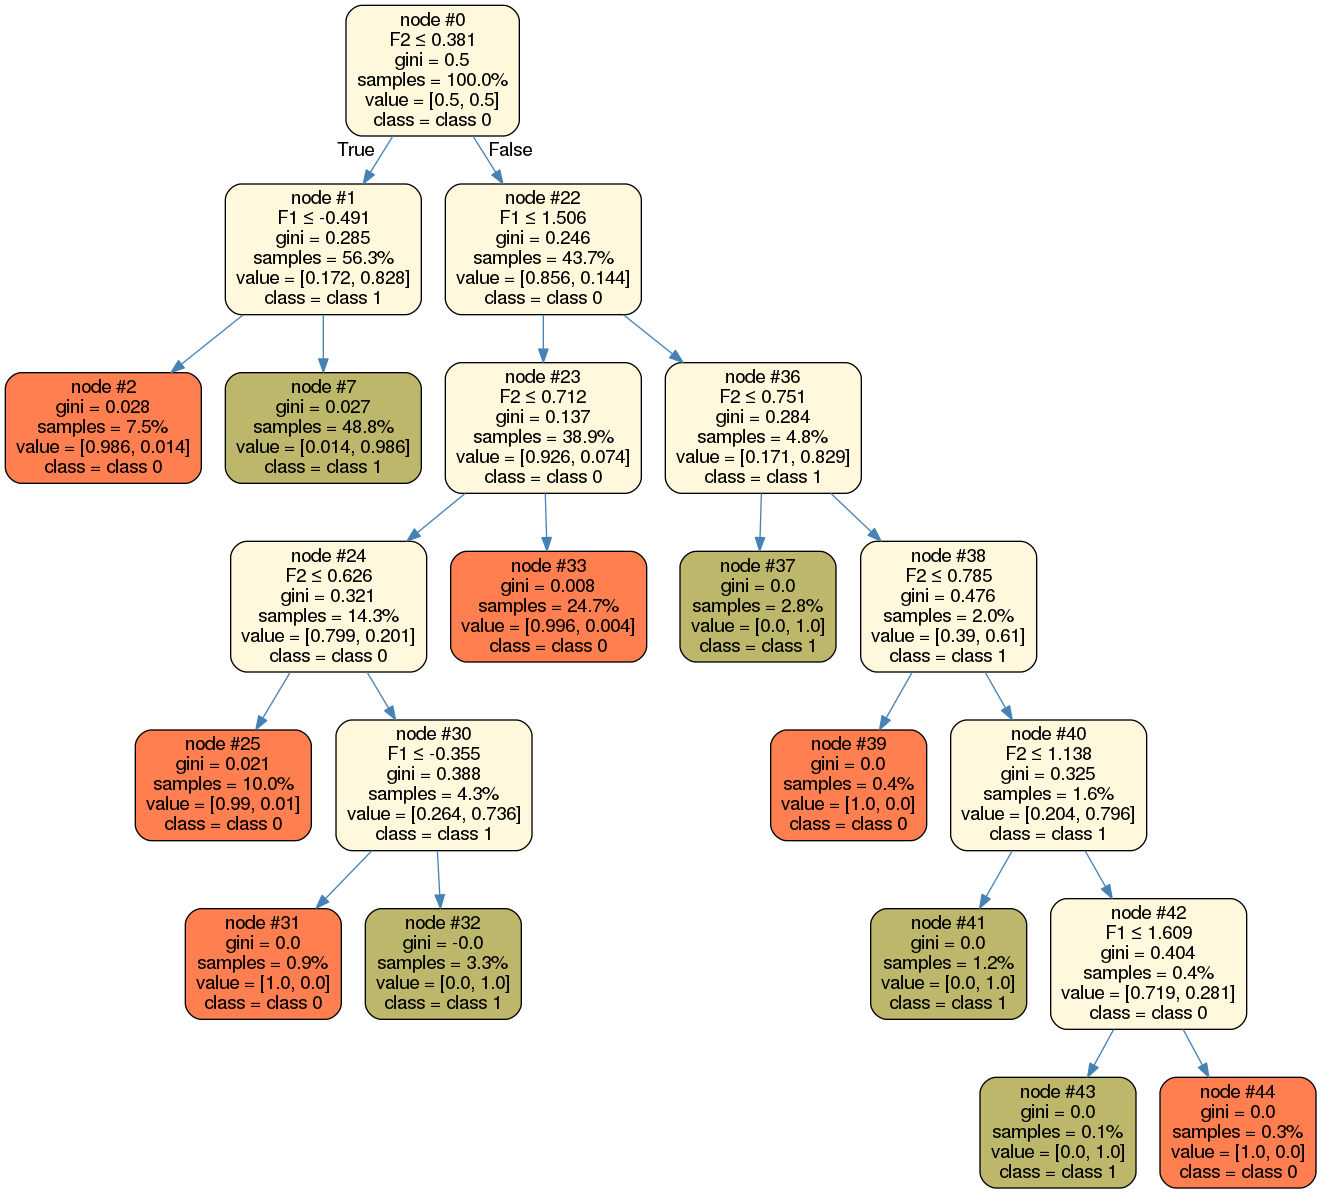

In [24]:
surrogate_explainer2.plot_global_decisions(colors=['coral', 'darkkhaki'], 
                                          file_name='test_tree_post.png')
show_in_notebook('test_tree_post.png', width=600, height=300)

In [25]:
y_hat_train_s_post = surrogate_explainer2.predict(X_train)
y_hat_s_post = surrogate_explainer2.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_post, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_post, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.91      0.79      0.85       380
    class 1       0.81      0.92      0.86       370

avg / total       0.86      0.86      0.86       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.86      0.80      0.83       120
    class 1       0.83      0.88      0.86       130

avg / total       0.85      0.84      0.84       250



### 3. Building better interpretable models

In [26]:
# One can also use TreeSurrogates to build Interpretable models not just surrogates
surrogate_explainer3 = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer3.learn(X_train, y_train, use_oracle=False, prune='pre')

2018-09-05 23:59:35,677 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-09-05 23:59:35,824 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (750,)
2018-09-05 23:59:35,826 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.849; oracle score 0.865
2018-09-05 23:59:35,827 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.016000000000000014 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


0.016000000000000014

In [27]:
y_hat_train_s_i = surrogate_explainer3.predict(X_train)
y_hat_s_i = surrogate_explainer3.predict(X_test)

print("\n--------Train dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_train, y_hat_train_s_i, target_names=target_names))

print("\n--------Test dataset classification report----------\n")
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_hat_s_i, target_names=target_names))


--------Train dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.89      0.80      0.84       380
    class 1       0.82      0.90      0.85       370

avg / total       0.85      0.85      0.85       750


--------Test dataset classification report----------

             precision    recall  f1-score   support

    class 0       0.86      0.81      0.83       120
    class 1       0.83      0.88      0.85       130

avg / total       0.84      0.84      0.84       250



2018-09-05 23:59:57,892 - skater.util.dataops - INFO - File Name: test_tree_interpretable.png


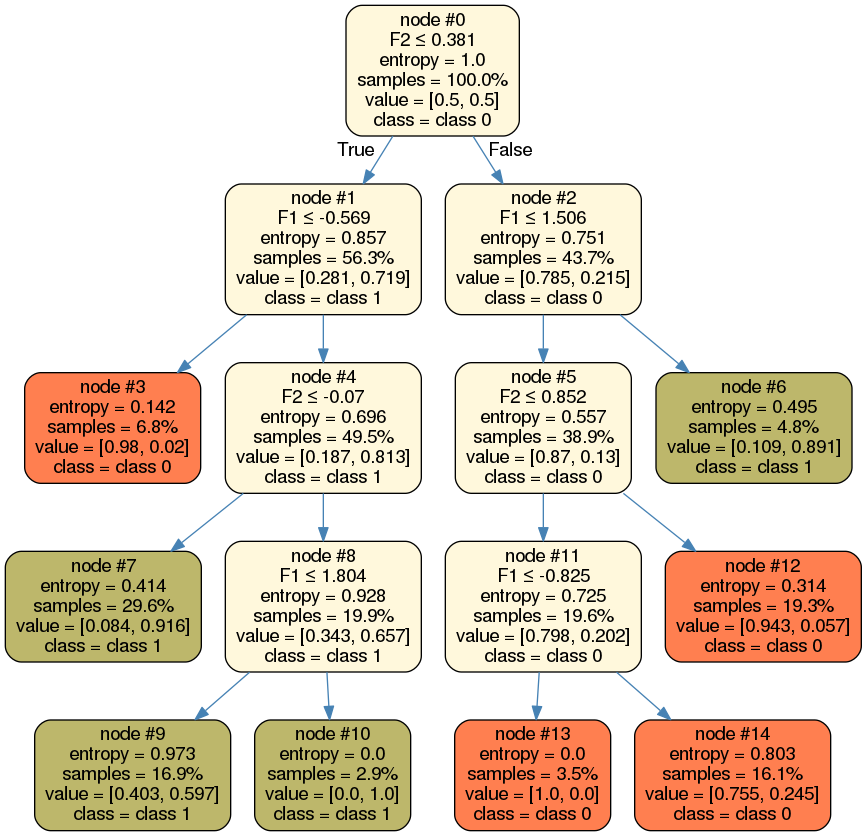

In [28]:
surrogate_explainer3.plot_global_decisions(colors=['coral', 'darkkhaki'], 
                                          file_name='test_tree_interpretable.png')
show_in_notebook('test_tree_interpretable.png', width=600, height=300)